In [10]:
import time
import os
import numpy as np 
from pathlib import Path
import argparse
import ffsim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib_inline
import ffsim
import pyscf
from sqd_lattice.pre_process import make_pyscf_slater_det,make_two_body_tensor
from sqd_lattice.util import load_pickle,load_yaml,save_pickle,load_json,save_json
import scienceplots
plt.style.use(['science'])

In [3]:
material = 'zirconia_2'
ne = "24"

folder_path = f"../runs/{material}/{ne}e"

# # # Loading data
base_config = load_yaml(f"../runs/{material}","base_config.yaml")
data = load_pickle(f"../runs/{material}","data_dict.pkl")
results_pre_process = load_pickle(folder_path,"results_pre_process.pkl")

two_body_tensor = results_pre_process["two_body_tensor"]

In [4]:
hopping_matrix = data["hopping_matrix"]
basis = data["orbital_basis"]

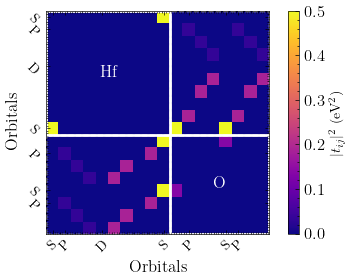

In [15]:
f,ax = plt.subplots(figsize=(4.2, 3))

# plot only the Gamma point
factor = 0.5
coeff = True
fontsize=12

list_of_orbitals = [f"{item['atom']}+{item['label']}" for item in basis]

absolute_matrix = np.array([[np.abs(item)**2 for item in row] for row in hopping_matrix])

# Create a list of labels corresponding to the elements
unique_elements = sorted(set(label.split('+')[0] for label in list_of_orbitals))
element_to_indices = {element: [i for i, label in enumerate(list_of_orbitals) if label.startswith(element)] for element in unique_elements}

# Create a list of orbital labels and their indices
orbital_labels = [label.split('+')[1][1:] for label in list_of_orbitals]
unique_orbitals = sorted(set(orbital_labels))

# Group labels
grouped_labels = []
grouped_index = []
current_label = None

for index,label in enumerate(orbital_labels):
    if label != current_label:
        grouped_labels.append(label)
        grouped_index.append(index)
        current_label = label

orbital_to_indices = {orbital: [i for i, orbital_label in enumerate(orbital_labels) if orbital_label == orbital] for orbital in unique_orbitals}
orbital_positions = {orbital: (min(indices) + max(indices)) / 2 for orbital, indices in orbital_to_indices.items()}

np.fill_diagonal(absolute_matrix,0)
vmin = np.min(abs(absolute_matrix))
vmax = np.max(abs(absolute_matrix))

absolute_matrix = abs(absolute_matrix)/vmax


im = ax.imshow(absolute_matrix, cmap='plasma', aspect='equal', vmax=factor, vmin=0)

cbar = f.colorbar(im, ax=ax, label='$|t_{ij}|^{2}$ (eV$^2$)', shrink=1.)

# set fontsize for ticks and label
cbar.ax.tick_params(labelsize=fontsize)  
cbar.ax.yaxis.label.set_size(fontsize-2)
# cbar.ax.text(1, 1.1, r'$\|t_{ij}\|^{2}_{max}$ = ' + f'{vmax:.2f} eV', transform=cbar.ax.transAxes, ha='left', va='top', fontsize=12)

for element, indices in element_to_indices.items():
    min_index = min(indices)
    max_index = max(indices)
    rect = patches.Rectangle((min_index - 0.5, min_index - 0.5), len(indices), len(indices),
                            linewidth=2, edgecolor='white', facecolor='none')
    ax.axhline(y=min_index - 0.5, color='white', linewidth=1, linestyle='--')
    ax.axhline(y=max_index + 0.5, color='white', linewidth=1, linestyle='--')
    ax.axvline(x=min_index - 0.5, color='white', linewidth=1, linestyle='--')
    ax.axvline(x=max_index + 0.5, color='white', linewidth=1, linestyle='--')
    f.gca().add_patch(rect)
    ax.text((min_index + max_index) / 2, (min_index + max_index) / 2, element, color='white', 
            fontsize=fontsize, ha='center', va='center', weight='bold')
    

ax.set_xticks(grouped_index, grouped_labels, rotation=45, ha='center', fontsize=fontsize-2)
ax.set_yticks(grouped_index, grouped_labels, rotation=-45, ha='right', fontsize=fontsize-2)
# plt.yticks([])
# plt.title('$\|t_{ij}\|^{2}_{max}$ = ' + f'{vmax:.2f} eV')
ax.set_ylabel('Orbitals',fontsize=fontsize)
ax.set_xlabel('Orbitals',fontsize=fontsize)
f.tight_layout()
plt.savefig(f"hopping_{material}.pdf")

In [5]:
num_orbitals = hopping_matrix.shape[0]
interaction_matrix = np.zeros((num_orbitals,num_orbitals))

for i in range(num_orbitals):
    for j in range(num_orbitals):
        interaction_matrix[i,j] = two_body_tensor[i,i,j,j]/2


In [6]:
interaction_matrix[np.nonzero(interaction_matrix)[1]]

array([[0.    , 0.    , 0.    , ..., 0.6392, 0.6392, 0.6392],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.6392, 0.6392, 0.6392],
       [0.    , 0.    , 0.    , ..., 0.6392, 0.6392, 0.6392],
       [0.    , 0.    , 0.    , ..., 0.6392, 0.6392, 0.6392]],
      shape=(65, 21))

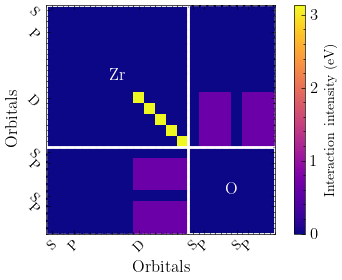

In [9]:
f,ax = plt.subplots(figsize=(4.2, 3))

# plot only the Gamma point
factor = 0.5
coeff = True
fontsize=12

list_of_orbitals = [f"{item['atom']}+{item['label']}" for item in basis]

absolute_matrix = interaction_matrix

# Create a list of labels corresponding to the elements
unique_elements = sorted(set(label.split('+')[0] for label in list_of_orbitals))
element_to_indices = {element: [i for i, label in enumerate(list_of_orbitals) if label.startswith(element)] for element in unique_elements}

# Create a list of orbital labels and their indices
orbital_labels = [label.split('+')[1][1:] for label in list_of_orbitals]
unique_orbitals = sorted(set(orbital_labels))

# Group labels
grouped_labels = []
grouped_index = []
current_label = None

for index,label in enumerate(orbital_labels):
    if label != current_label:
        grouped_labels.append(label)
        grouped_index.append(index)
        current_label = label

orbital_to_indices = {orbital: [i for i, orbital_label in enumerate(orbital_labels) if orbital_label == orbital] for orbital in unique_orbitals}
orbital_positions = {orbital: (min(indices) + max(indices)) / 2 for orbital, indices in orbital_to_indices.items()}

# np.fill_diagonal(absolute_matrix,0)
# vmin = np.min(absolute_matrix)
# vmax = np.max(absolute_matrix)

# absolute_matrix = abs(absolute_matrix)/vmax


im = ax.imshow(absolute_matrix, cmap='plasma', aspect='equal', 
            #    vmax=factor, 
            #    vmin=0,
               )

cbar = f.colorbar(im, ax=ax, label='Interaction intensity (eV)', shrink=1.)

# set fontsize for ticks and label
cbar.ax.tick_params(labelsize=fontsize)  
cbar.ax.yaxis.label.set_size(fontsize-2)
# cbar.ax.text(1, 1.1, r'$\|t_{ij}\|^{2}_{max}$ = ' + f'{vmax:.2f} eV', transform=cbar.ax.transAxes, ha='left', va='top', fontsize=12)

for element, indices in element_to_indices.items():
    min_index = min(indices)
    max_index = max(indices)
    rect = patches.Rectangle((min_index - 0.5, min_index - 0.5), len(indices), len(indices),
                            linewidth=2, edgecolor='white', facecolor='none')
    ax.axhline(y=min_index - 0.5, color='white', linewidth=1, linestyle='--')
    ax.axhline(y=max_index + 0.5, color='white', linewidth=1, linestyle='--')
    ax.axvline(x=min_index - 0.5, color='white', linewidth=1, linestyle='--')
    ax.axvline(x=max_index + 0.5, color='white', linewidth=1, linestyle='--')
    f.gca().add_patch(rect)
    if element=="O":
        ax.text((min_index + max_index) / 2, (min_index + max_index) / 2, element, color='white', 
                fontsize=fontsize, ha='center', va='center', weight='bold')
    else:
        ax.text((min_index + max_index) / 2, (min_index + max_index) / 2, element, color='white', 
                fontsize=fontsize, ha='center', va='center', weight='bold')    

ax.set_xticks(grouped_index, grouped_labels, rotation=45, ha='center', fontsize=fontsize-2)
ax.set_yticks(grouped_index, grouped_labels, rotation=-45, ha='right', fontsize=fontsize-2)
# plt.yticks([])
# plt.title('$\|t_{ij}\|^{2}_{max}$ = ' + f'{vmax:.2f} eV')
ax.set_ylabel('Orbitals',fontsize=fontsize)
ax.set_xlabel('Orbitals',fontsize=fontsize)
f.tight_layout()
plt.savefig(f"interaction_{material}.pdf")